# Pangeo Exploration Part I:
## Exploring Initial TSMP Dataset

### NOTE!
**Do not run this Notebook, as I haven't included the very large data files which it uses. Refer to it as a static notebook**

## Overview

Xarray was tailored to work natively with  the netCDF data format, which was designed to be a portable and self-describing format for scientific datasets. It's heavily used in meteorology and climate science, but I had to do some digging to find a dataset with direct groundwater data.<br>
I found this [Nature Publication](https://www.nature.com/articles/s41597-019-0328-7#Abs1), who's authors paired atmospheric data with soil and groundwater data. For this sample project I'm just using some of the groundwater data to limit the scope. In reality it's **gridded simulation results** and not actual raw data, but I'll refer to it as a **dataset** here for simplicity<br>
Here's the [Dataset](https://datapub.fz-juelich.de/slts/cordex/data/wtd/)

In this notebook, I import the dataset, clean it up a bit, and export a smaller portion of it to do further analysis on in the next notebook "iberian-eda.ipynb"

<hr>

## Importing the Data

In [24]:
import xarray as xr
import dask as da
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cartopy import crs as ccrs, feature as cfeature
%matplotlib inline

In [25]:
da.config.set(**{'array.slicing.split_large_chunks': True})

In [26]:
ds = xr.open_mfdataset('data/2017/*.nc', compat='override', chunks={'time':50})
ds

<xarray.Dataset>
Dimensions:       (lev: 15, time: 365, bnds: 2, rlon: 424, rlat: 412)
Coordinates:
  * lev           (lev) float64 1.0 2.0 3.0 4.0 5.0 ... 11.0 12.0 13.0 14.0 15.0
  * time          (time) datetime64[ns] 2017-01-01T10:30:00 ... 2017-12-31T10...
  * rlon          (rlon) float64 -28.48 -28.37 -28.26 ... 17.83 17.94 18.05
  * rlat          (rlat) float64 -23.48 -23.37 -23.26 ... 21.51 21.62 21.73
Dimensions without coordinates: bnds
Data variables:
    time_bnds     (time, bnds) datetime64[ns] dask.array<chunksize=(50, 2), meta=np.ndarray>
    rotated_pole  int32 ...
    pgw           (time, lev, rlat, rlon) float64 dask.array<chunksize=(50, 15, 412, 424), meta=np.ndarray>
    sgw           (time, lev, rlat, rlon) float64 dask.array<chunksize=(50, 15, 412, 424), meta=np.ndarray>
    wtd           (time, lev, rlat, rlon) float64 dask.array<chunksize=(50, 1, 412, 424), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.3 (http://mpimet.mpg.de/...
    Conventions:  CF-1.4
    frequency:    day
    CDO:          Climate Data Operators version 1.9.3 (http://mpimet.mpg.de/...
    history:      Thu Jan 17 13:15:32 2019: ncatted -a unit,pgw,c,c,m H2O /p/...
    NCO:          "4.6.5"

Giving Dimensions More Semantic Names

In [27]:
ds = ds.rename_vars({'pgw':'pressure', 'sgw':'saturation', 'wtd': 'water_table'})

## Mask for Land vs Water

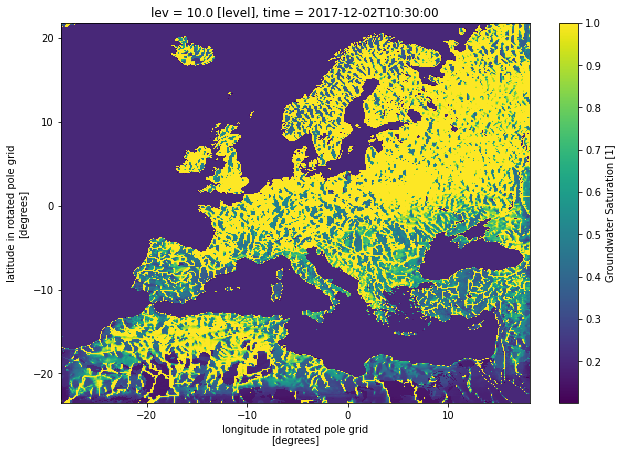

In [28]:
ds.saturation.sel(time='2017-12-02', lev=10.0).plot(size=7)

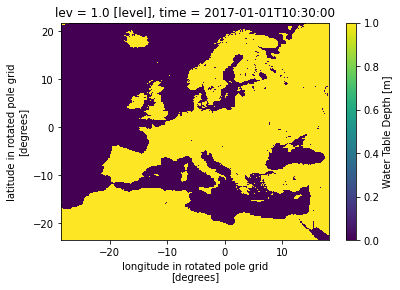

In [29]:
mask_array = np.ones(
    (ds.dims['rlat'], 
     ds.dims['rlon'])) * np.isfinite(ds.water_table.isel(time=0, lev=0))  
mask_array.plot()

In [30]:
ds.coords['mask'] = (('rlat', 'rlon'), mask_array.data)
ds

<xarray.Dataset>
Dimensions:       (lev: 15, time: 365, bnds: 2, rlon: 424, rlat: 412)
Coordinates:
  * lev           (lev) float64 1.0 2.0 3.0 4.0 5.0 ... 11.0 12.0 13.0 14.0 15.0
  * time          (time) datetime64[ns] 2017-01-01T10:30:00 ... 2017-12-31T10...
  * rlon          (rlon) float64 -28.48 -28.37 -28.26 ... 17.83 17.94 18.05
  * rlat          (rlat) float64 -23.48 -23.37 -23.26 ... 21.51 21.62 21.73
    mask          (rlat, rlon) float64 dask.array<chunksize=(412, 424), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    time_bnds     (time, bnds) datetime64[ns] dask.array<chunksize=(50, 2), meta=np.ndarray>
    rotated_pole  int32 ...
    pressure      (time, lev, rlat, rlon) float64 dask.array<chunksize=(50, 15, 412, 424), meta=np.ndarray>
    saturation    (time, lev, rlat, rlon) float64 dask.array<chunksize=(50, 15, 412, 424), meta=np.ndarray>
    water_table   (time, lev, rlat, rlon) float64 dask.array<chunksize=(50, 1, 412, 424), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.3 (http://mpimet.mpg.de/...
    Conventions:  CF-1.4
    frequency:    day
    CDO:          Climate Data Operators version 1.9.3 (http://mpimet.mpg.de/...
    history:      Thu Jan 17 13:15:32 2019: ncatted -a unit,pgw,c,c,m H2O /p/...
    NCO:          "4.6.5"

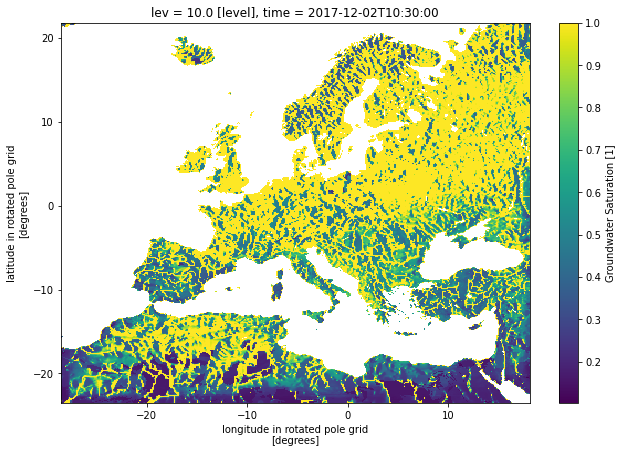

In [31]:
ds.saturation.sel(time='2017-12-02', lev=10.0) \
    .where(ds.mask == 1).plot(size=7)

## Map Projections and CRS

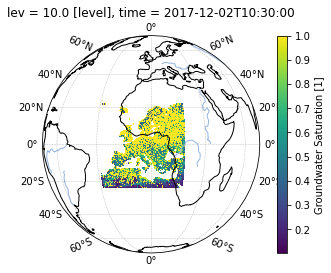

In [32]:
fig = ds.saturation.sel(time='2017-12-02', lev=10.0).where(ds.mask == 1).plot(
     subplot_kws=dict(projection=ccrs.Orthographic(), facecolor="white"),
     transform=ccrs.PlateCarree(),
     )
fig.axes.gridlines(
    draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--'
)
fig.axes.set_global()
fig.axes.add_feature(cfeature.RIVERS)
fig.axes.coastlines()

In [33]:
ds_rotated_pole = ccrs.RotatedPole(
    ds.rotated_pole.grid_north_pole_longitude, 
    ds.rotated_pole.grid_north_pole_latitude,)
ds_rotated_pole

In [34]:
normal_pole = ccrs.RotatedPole(0, 0)
normal_pole

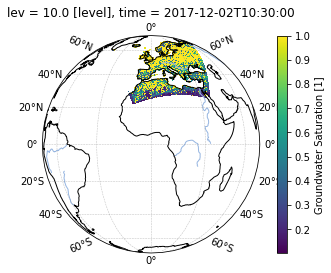

In [35]:
fig = ds.saturation.sel(time=date, lev=10.0).where(ds.mask == 1).plot(
     subplot_kws=dict(projection=ccrs.Orthographic(), facecolor="white"),
     transform=ds_rotated_pole,
     )
fig.axes.gridlines(
    draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--'
)
fig.axes.set_global()
fig.axes.add_feature(cfeature.RIVERS)
fig.axes.coastlines()

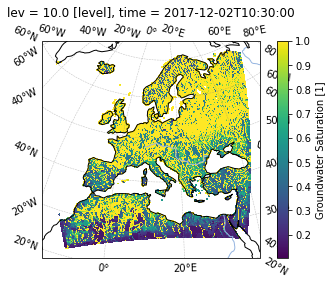

In [36]:
fig = ds.saturation.sel(time=date, lev=10.0).where(ds.mask == 1).plot(
    subplot_kws=dict(projection=ccrs.Orthographic(
        central_longitude=15, central_latitude=35), 
        facecolor="white"),
    transform=ds_rotated_pole,
    )
fig.axes.gridlines(
    draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--'
)
# fig.axes.set_global()
fig.axes.add_feature(cfeature.RIVERS)
fig.axes.coastlines()

## Pulling a Subset of the Data: The Iberian Peninsula

In [37]:
min_lon = -22
min_lat = -12
max_lon = -11
max_lat = -3.5

mask_lon = (ds.rlon >= min_lon) & (ds.rlon <= max_lon)
mask_lat = (ds.rlat >= min_lat) & (ds.rlat <= max_lat)

iberian = ds.where(mask_lon & mask_lat, drop=True)

In [38]:
iberian

<xarray.Dataset>
Dimensions:       (time: 365, bnds: 2, rlon: 100, rlat: 77, lev: 15)
Coordinates:
  * lev           (lev) float64 1.0 2.0 3.0 4.0 5.0 ... 11.0 12.0 13.0 14.0 15.0
  * time          (time) datetime64[ns] 2017-01-01T10:30:00 ... 2017-12-31T10...
  * rlon          (rlon) float64 -21.99 -21.88 -21.77 ... -11.32 -11.21 -11.1
  * rlat          (rlat) float64 -11.93 -11.82 -11.71 ... -3.792 -3.682 -3.572
    mask          (rlat, rlon) float64 dask.array<chunksize=(77, 100), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    time_bnds     (time, bnds, rlon, rlat) datetime64[ns] dask.array<chunksize=(50, 2, 100, 77), meta=np.ndarray>
    rotated_pole  (rlon, rlat) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    pressure      (time, lev, rlat, rlon) float64 dask.array<chunksize=(50, 15, 26, 8), meta=np.ndarray>
    saturation    (time, lev, rlat, rlon) float64 dask.array<chunksize=(50, 15, 26, 8), meta=np.ndarray>
    water_table   (time, lev, rlat, rlon) float64 dask.array<chunksize=(50, 1, 26, 8), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.3 (http://mpimet.mpg.de/...
    Conventions:  CF-1.4
    frequency:    day
    CDO:          Climate Data Operators version 1.9.3 (http://mpimet.mpg.de/...
    history:      Thu Jan 17 13:15:32 2019: ncatted -a unit,pgw,c,c,m H2O /p/...
    NCO:          "4.6.5"

In [39]:
# Exporting the cleaned up dataset
# Currently a raw cell so it doesn't keep saving to file
iberian.to_netcdf('iberian.nc')